Import Modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from torch.optim import Adam
import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image
import os
import csv
from PIL import Image

Hyperperameters

In [ ]:
label_path = "map_images/labels.csv"
dataset_path = "map_images/"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

kwargs = {'num_workers': 2, 'pin_memory': True} 

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-4

epochs = 500

# Model parameters
input_channels = 3
latent_dim = 20

Model Architecture

In [22]:
# Devine the Encoder
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 128, 128)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: (64, 64, 64)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 32, 32)
        self.flatten = nn.Flatten()
        self.fc_mean = nn.Linear(32 ** 3, latent_dim)
        self.fc_log_var = nn.Linear(32 ** 3, latent_dim)

        self.relu = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        mean = self.fc_mean(x)
        log_var = self.fc_log_var(x)
        return mean, log_var

#Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 32 ** 3)
        self.deconv1 = nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1) # Output: (64, 64, 64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: (32, 128, 128)
        self.deconv3 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)  # Output: (3, 256, 256)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 32, 32, 32)  # Reshape to spatial dimensions
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))  # Sigmoid to constrain outputs between 0 and 1
        x = torch.sigmoid(self.deconv3(x))
        return x

class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std).to(DEVICE)
        return mean + eps * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

def loss_function(reconstructed, original, mean, log_var):
    # Reconstruction loss
    reconstruction_loss = F.mse_loss(reconstructed, original, reduction='sum')
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence


In [ ]:
# Train on our dataset
image_dataset = ImageDataset(label_path, dataset_path)

#Split into train and test sets
indices = list(range(len(image_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)  # 80% train, 20% test
train_dataset = Subset(image_dataset, train_indices)
test_dataset = Subset(image_dataset, test_indices)


Train Loop

In [ ]:
# Create a new DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

# Define model
vae = VAE(input_channels, latent_dim).to(DEVICE)

# Optimizer
optimizer = Adam(vae.parameters(), lr=lr)

# Training loop
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(torch.float32)
        images = images.to(DEVICE)

        optimizer.zero_grad()
        reconstructed, mean, log_var = vae(images)
        loss = loss_function(reconstructed, images, mean, log_var)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    

# Saving the model and optimizer
torch.save({
    'model_state_dict': vae.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, "demo_VAE_checkpoint.pth")

Epoch 1, Loss: 1542193.2518
Epoch 2, Loss: 341820.9806
Epoch 3, Loss: 211194.6711
Epoch 4, Loss: 177645.2438
Epoch 5, Loss: 164640.3217
Epoch 6, Loss: 157761.9948
Epoch 7, Loss: 153085.2797
Epoch 8, Loss: 149675.4592
Epoch 9, Loss: 146818.4091
Epoch 10, Loss: 144465.4993
Epoch 11, Loss: 142254.9214
Epoch 12, Loss: 140294.1961
Epoch 13, Loss: 138095.2104
Epoch 14, Loss: 135752.2270
Epoch 15, Loss: 133234.9436
Epoch 16, Loss: 130373.2613
Epoch 17, Loss: 126789.4139
Epoch 18, Loss: 123317.4679
Epoch 19, Loss: 120524.2660
Epoch 20, Loss: 117927.1815
Epoch 21, Loss: 115916.8491
Epoch 22, Loss: 114083.1590
Epoch 23, Loss: 112416.6059
Epoch 24, Loss: 111000.0670
Epoch 25, Loss: 109474.0851
Epoch 26, Loss: 108296.2069
Epoch 27, Loss: 106913.4648
Epoch 28, Loss: 105756.7697
Epoch 29, Loss: 104581.0555
Epoch 30, Loss: 103462.4867
Epoch 31, Loss: 102535.8634
Epoch 32, Loss: 101605.0117
Epoch 33, Loss: 100821.6566
Epoch 34, Loss: 100110.7539
Epoch 35, Loss: 99324.4081
Epoch 36, Loss: 98615.0855
Ep

Test Loop

In [50]:
test_loader = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

# Reloading the model and optimizer
checkpoint = torch.load("demo_VAE_checkpoint.pth")
vae = VAE(input_channels=input_channels, latent_dim=latent_dim)  # Reinitialize model
vae.load_state_dict(checkpoint['model_state_dict'])
vae.to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)  # Reinitialize optimizer
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

vae.eval()
for batch_idx, (test_images, _) in enumerate(test_loader):
    test_images = test_images.to(DEVICE)
    reconstructed, mean, log_var = vae(test_images)
    loss = loss_function(reconstructed, test_images, mean, log_var)
print(loss.item() / batch_size)


C:\Users\Aes\AppData\Local\Temp\ipykernel_12552\3830646901.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("demo_VAE_checkpoint.pth")


295.619921875


In [27]:
def show_image(original_batch, reconstructed_batch, index):
    # Extract the specific image and move to CPU
    original = original_batch[index].detach().cpu()
    reconstructed = reconstructed_batch[index].detach().cpu()

    transform = T.Compose([
    T.ToPILImage()
    ])
    
    
    original = transform(original)
    reconstructed = transform(reconstructed)
    
        
    # Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    
    # Original image
    axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # Reconstructed image
    axes[1].imshow(reconstructed)
    axes[1].set_title("Generated")
    axes[1].axis('off')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

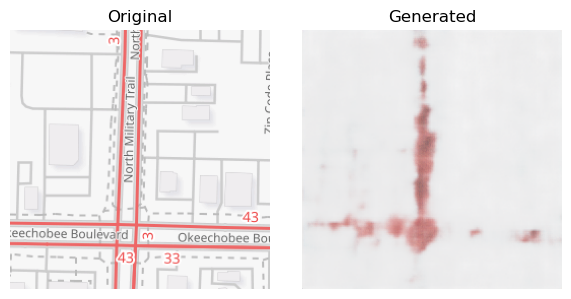

In [62]:
show_image(test_images, reconstructed, index=8)